## Fine-Tuning --- Con't

Project -> Given a description of a product, predict its Price 

A model that can estimate how much something costs, from its description.

### Baseline Models

Today we work on the simplest models to act as a starting point that we will beat.

In [1]:
# imports
import os
import random
import pickle
import numpy as np
from items import Item
from dotenv import load_dotenv
from loaders import ItemLoader
import matplotlib.pyplot as plt
from huggingface_hub import login
from collections import Counter, defaultdict
from datasets import load_dataset, Dataset, DatasetDict

c:\Users\tazeb\OneDrive\AtomicHabit\LLM Engineering\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\tazeb\OneDrive\AtomicHabit\LLM Engineering\venv\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
# environment
load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

# Log in to HuggingFace
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## Fine Tuning with Fontier model (GPT)

And now - we put Frontier Models to the test.

### 2 important points:

It's important to appreciate that we aren't Training the frontier models. We're only providing them with the ***Test dataset*** to see how they perform. They don't gain the benefit of the 400,000 training examples that we provided to the Traditional ML models.

HAVING SAID THAT...

It's entirely possible that in their monstrously large training data, they've already been exposed to all the products in the training AND the test set. So there could be test "contamination" here which gives them an unfair advantage. We should keep that in mind.

In [3]:
import re
import openai
from testing import Tester
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [4]:
%matplotlib inline

# Let's avoid curating all our data again! Load in the pickle files:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [5]:
# GPT-4o-mini

In [6]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [7]:
messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [8]:
# A utility function to extract the price from a string
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [9]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [10]:
def gpt_4(item):
    response = openai.ChatCompletion.create(
        model="gpt-4",  # Use the correct model name (e.g., "gpt-4" or similar)
        messages=messages_for(item),
        max_tokens=5,
        temperature=0.7
    )
    reply = response['choices'][0]['message']['content']
    return get_price(reply)


In [11]:
test[0].price

374.41

In [12]:
gpt_4(test[0])

250.0

1: Guess: $250.00 Truth: $374.41 Error: $124.41 SLE: 0.16 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $200.00 Truth: $225.11 Error: $25.11 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $59.99 Truth: $61.68 Error: $1.69 SLE: 0.00 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $599.99 Truth: $599.99 Error: $0.00 SLE: 0.00 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $15.99 Truth: $16.99 Error: $1.00 SLE: 0.00 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $25.99 Truth: $31.99 Error: $6.00 SLE: 0.04 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $105.99 Truth: $101.79 Error: $4.20 SLE: 0.00 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $289.00 Truth: $289.00 Error: $0.00 SLE: 0.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $450.00 Truth: $635.86 Error: $185.86 SLE: 0.12 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $99.99 Truth: $65.99 Error: $34.00 SLE: 0.17 Item: 

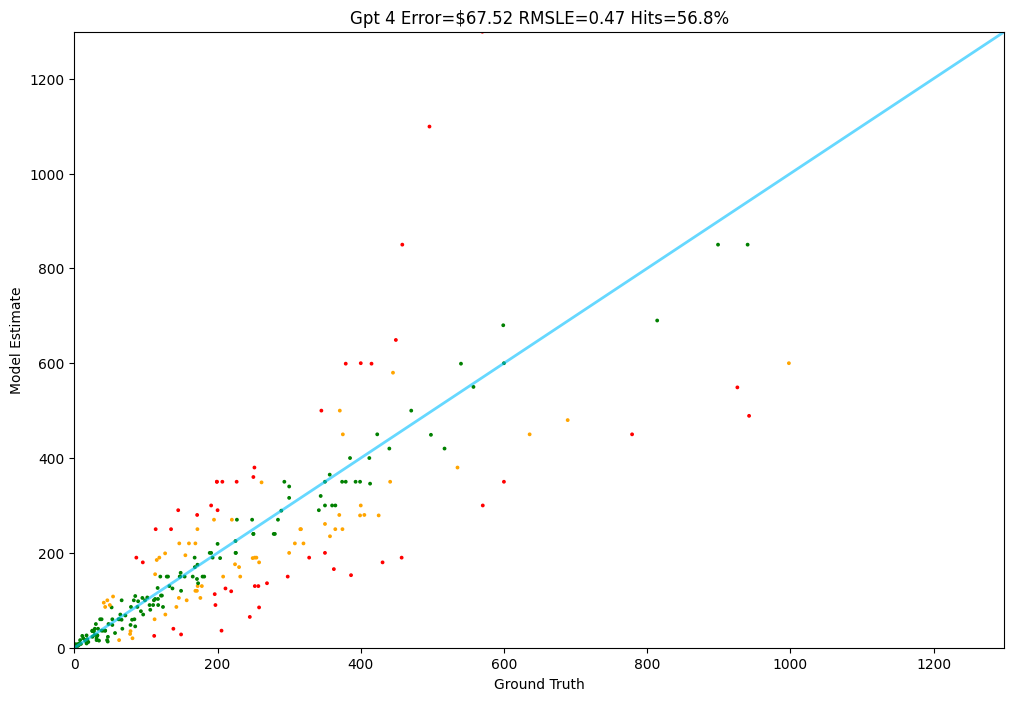

In [13]:
Tester.test(gpt_4, test)

In [14]:
# other models

def gpt_4o_frontier(item):
    response = openai.ChatCompletion.create(
        model="gpt-4o-2024-08-06",  # Use the correct model name (e.g., "gpt-4" or similar)
        messages=messages_for(item),
        max_tokens=5,
        temperature=0.7
    )
    reply = response['choices'][0]['message']['content']
    return get_price(reply)


In [15]:
gpt_4o_frontier(test[0])

270.0

1: Guess: $250.00 Truth: $374.41 Error: $124.41 SLE: 0.16 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $60.00 Truth: $225.11 Error: $165.11 SLE: 1.72 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $56.99 Truth: $61.68 Error: $4.69 SLE: 0.01 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $450.00 Truth: $599.99 Error: $149.99 SLE: 0.08 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $20.00 Truth: $16.99 Error: $3.01 SLE: 0.02 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.99 Truth: $31.99 Error: $16.00 SLE: 0.44 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $99.99 Truth: $101.79 Error: $1.80 SLE: 0.00 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $299.00 Truth: $289.00 Error: $10.00 SLE: 0.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $350.00 Truth: $635.86 Error: $285.86 SLE: 0.35 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $40.00 Truth: $65.99 Error: $25.99 SLE: 0.24 Ite

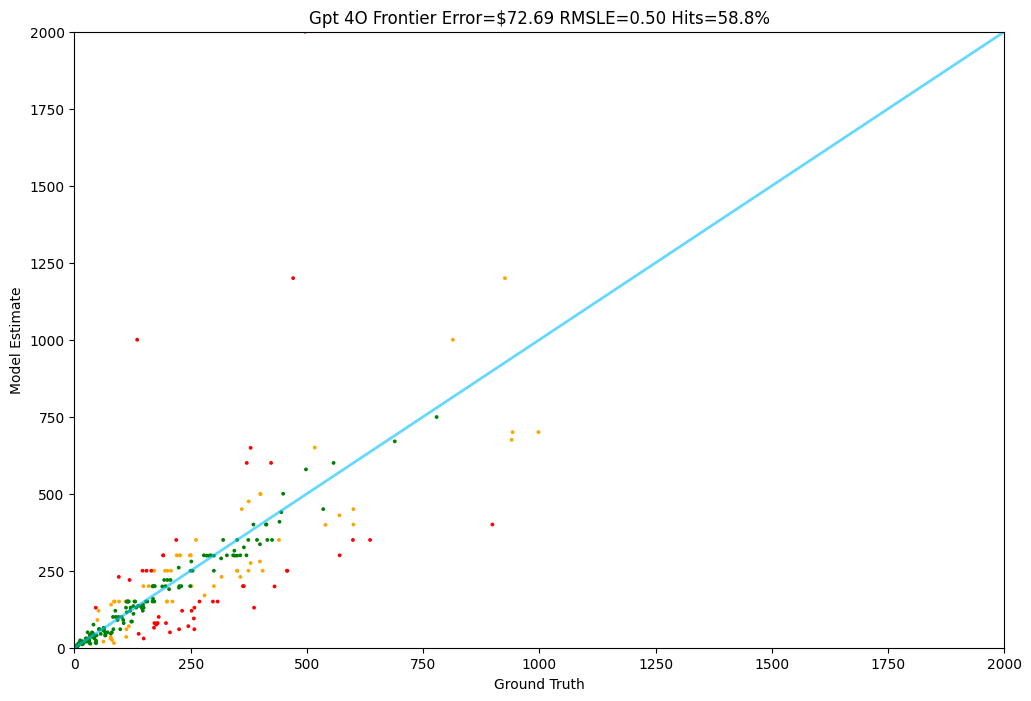

In [16]:
Tester.test(gpt_4o_frontier, test)